## Import Libraries

In [1]:
import re
import nltk
import math
import torch
import pandas as pd
import sklearn.model_selection
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import BartForConditionalGeneration, AutoTokenizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
!pip install accelerate bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 4.3 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
url = "/content/gdrive/MyDrive/mtsamples.csv"    # Change path

In [5]:
# Use pandas to read the dataset directly from the URL
data = pd.read_csv(url)
data.shape

(4999, 6)

In [6]:
# Display the first few rows of the dataset
data.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [7]:
def get_transcription():
  transcription = data[["transcription", "keywords"]]
  return transcription

In [8]:
data = get_transcription()
data.head()

,transcription,keywords
0,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


## Removing NULL and Duplicate Values


In [9]:
data.isnull().sum()   # Checking NULL values in the remaining dataset

transcription      33
keywords         1068
dtype: int64

In [10]:
# Removing Null Values from both the features
data = data[~(data['transcription'].isnull())]
data = data[~(data['keywords'].isnull())]

In [11]:
data.isnull().sum()   # Checking NULL values in the remaining dataset

transcription    0
keywords         0
dtype: int64

In [12]:
data.duplicated().sum()

46

In [13]:
data=data.drop_duplicates()   # Drop Duplicate data
data.shape

(3852, 2)

In [14]:
data.head()

,transcription,keywords
0,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."




```
# This is formatted as code
```

## Data Cleaning and Lemmatization

In [15]:
def cleaning(input):
    pattern = r'[^a-zA-Z0-9\s]'                  # Keep only alphanumeric characters and whitespace
    cleaned_string = re.sub(pattern, '', input)  # Using re.sub, eliminating special characters
    lowercased_string = cleaned_string.lower()   # Lowercasing the string

    return lowercased_string

In [16]:
data['transcription'] = data['transcription'].apply(cleaning)
data['keywords'] = data['keywords'].apply(cleaning)

In [17]:
data.head()

,transcription,keywords
0,subjective this 23yearold white female presen...,allergy immunology allergic rhinitis allergie...
1,past medical history he has difficulty climbin...,bariatrics laparoscopic gastric bypass weight ...
2,history of present illness i have seen abc to...,bariatrics laparoscopic gastric bypass heart a...
3,2d mmode 1 left atrial enlargement with left...,cardiovascular pulmonary 2d mmode doppler aor...
4,1 the left ventricular cavity size and wall t...,cardiovascular pulmonary 2d doppler echocardi...


In [18]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [19]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

In [20]:
data['transcription']=data['transcription'].apply(remove_stopwords)

In [21]:
data.head()

,transcription,keywords
0,subjective 23yearold white female presents com...,allergy immunology allergic rhinitis allergie...
1,past medical history difficulty climbing stair...,bariatrics laparoscopic gastric bypass weight ...
2,history present illness seen abc today pleasan...,bariatrics laparoscopic gastric bypass heart a...
3,2d mmode 1 left atrial enlargement left atrial...,cardiovascular pulmonary 2d mmode doppler aor...
4,1 left ventricular cavity size wall thickness ...,cardiovascular pulmonary 2d doppler echocardi...


## Training / Fine Tuning

In [22]:
class MTSamples(Dataset):
    def __init__(self, transcript, keywords, tokenizer, df, in_len, out_len):
        self.transcript = transcript
        self.keywords = keywords
        self.tokenizer = tokenizer
        self.df = df
        self.in_len = in_len
        self.out_len = out_len

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        transcript_tokens = self.tokenizer(self.df[self.transcript].iloc[idx], padding='max_length', truncation=True,
                                          max_length=self.in_len, return_tensors='pt')['input_ids'].to(device)
        keyword_tokens = self.tokenizer(self.df[self.keywords].iloc[idx], padding="max_length", truncation=True,
                                       max_length=self.out_len,return_tensors='pt')['input_ids'].to(device)

        return transcript_tokens[0,:], keyword_tokens[0,:]


In [23]:
transcription = data['transcription'].apply(lambda x: len(x.split()))
transcription.head()

0    109
1    238
2    442
3     55
4    164
Name: transcription, dtype: int64

In [24]:
keywords = data['keywords'].apply(lambda x: len(x.split()))
keywords.head()

0    14
1    28
2    27
3    28
4    34
Name: keywords, dtype: int64

In [25]:
# Finding maximum length in keywords
mx=0
for i in data['keywords']:
    mx = max(mx, len(i.split()));
print("Maximum number of characters in \"keywords\" is ", mx)

Maximum number of characters in "keywords" is  118


In [26]:
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base", padding_side="left", truncation_side='right')
model = BartForConditionalGeneration.from_pretrained("facebook/bart-base").to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

In [27]:
tokenizer

BartTokenizerFast(name_or_path='facebook/bart-base', vocab_size=50265, model_max_length=1024, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50264: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True, special=True),
}

In [28]:
### Splitting the data to train and test sets
train_data, validate_data = train_test_split(data, train_size=0.8, random_state=34)

train_model = MTSamples('transcription','keywords', tokenizer, train_data, 512, 120)
validate_model = MTSamples('transcription','keywords', tokenizer, validate_data, 512, 120)

In [29]:
### Converting dataset object to dataloader object
batch_size = 4
train_loader = DataLoader(train_model, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_model, batch_size=batch_size, shuffle=True)

In [30]:
def num_batches(total, batch_size):
    return math.ceil(total / batch_size)

In [31]:
epochs = 5
batch_size=4
optimizer = Adam(model.parameters(),lr=2e-4)
train_batches = num_batches(train_data.shape[0], batch_size)
validate_batches = num_batches(validate_data.shape[0], batch_size)
losses = []
epochss = []
accuracies=[]

In [32]:
def train(data,num_batches, model, optimizer, epoch):
    model.train()
    model_acc = 0
    model_loss = 0
    i = 0
    for transcript, keyWord in data:
        optimizer.zero_grad()
        out = model(transcript, labels=keyWord)   # Feed forward Pass
        loss = out.loss                           # Loss computation
        model_loss += loss.item()

        logits = out.logits
        preds = torch.softmax(logits,dim=2)
        preds = torch.argmax(preds,dim=2)
        acc = torch.sum(keyWord == preds).item()/(keyWord.shape[0]*keyWord.shape[1])
        model_acc += acc

        loss.backward()             # Backpropogation
        optimizer.step()

        i+=1
        print(f"loss={model_loss/i} accuracy={model_acc/i}", end="\r")
    print(f"Epoch={epoch+1}, Loss={round(model_loss/i, 4)}, Accuracy={round(model_acc/i*100, 2)} %", end="\n")
    epochss.append(epoch+1)
    losses.append(round(model_loss/i, 3))
    accuracies.append(round(model_acc/i*100, 2))

In [33]:
def test(data, num_batches, model):
    model.eval()
    model_acc = 0
    model_loss = 0
    i = 0
    for transcript, keyWord in data:
        out = model(transcript, labels=keyWord)   # Feed forward Pass
        loss = out.loss                           # Loss computation
        model_loss += loss.item()

        logits = out.logits
        preds = torch.softmax(logits,dim=2)
        preds = torch.argmax(preds,dim=2)
        acc = torch.sum(keyWord == preds).item()/(keyWord.shape[0]*keyWord.shape[1])
        model_acc += acc
        i+=1
        # No Backpropogation as it is evaluation of model

    print(f"Test Loss={round(model_loss/i, 4)}, Test Accuracy={round(model_acc/i*100, 2)} %", end="\n")

In [34]:
for e in range(epochs):
    train(train_loader, train_batches, model, optimizer, e)

Epoch=1, Loss=1.3973, Accuracy=79.18 %
Epoch=2, Loss=0.8895, Accuracy=84.5 %
Epoch=3, Loss=0.6434, Accuracy=87.3 %
Epoch=4, Loss=0.5713, Accuracy=87.92 %
Epoch=5, Loss=0.4354, Accuracy=89.88 %


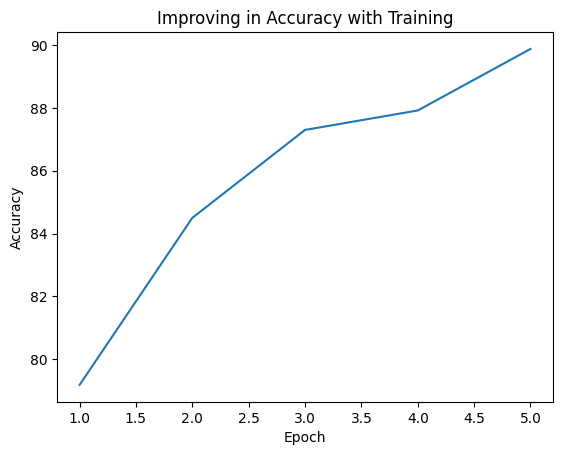

In [35]:
plt.plot(epochss, accuracies)
plt.title("Improving in Accuracy with Training")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

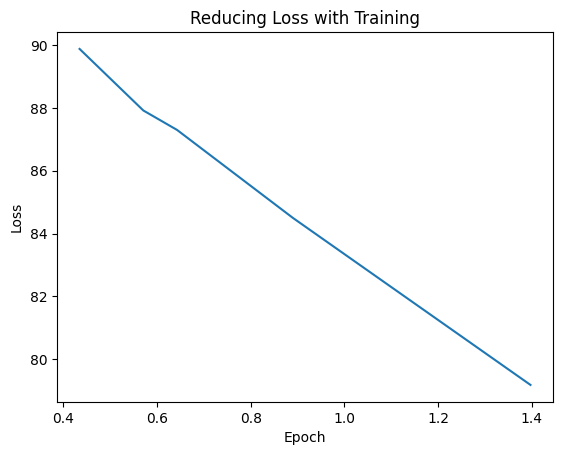

In [36]:
plt.plot(losses, accuracies)
plt.title("Reducing Loss with Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [38]:
test(validate_loader, validate_batches, model)

Test Loss=0.4849, Test Accuracy=89.61 %


In [39]:
torch.save(model.state_dict(), '/content/gdrive/MyDrive/medical5.pth')

In [40]:
data.shape

(3852, 2)

In [41]:
data.head()

,transcription,keywords
0,subjective 23yearold white female presents com...,allergy immunology allergic rhinitis allergie...
1,past medical history difficulty climbing stair...,bariatrics laparoscopic gastric bypass weight ...
2,history present illness seen abc today pleasan...,bariatrics laparoscopic gastric bypass heart a...
3,2d mmode 1 left atrial enlargement left atrial...,cardiovascular pulmonary 2d mmode doppler aor...
4,1 left ventricular cavity size wall thickness ...,cardiovascular pulmonary 2d doppler echocardi...


In [42]:
def generate_keywords(df, transcription, model, tokenizer):
    df['Result'] = df[transcription].apply(lambda x: tokenizer(x, max_length=512, padding='max_length',
                                                      truncation=True, return_tensors='pt')['input_ids'])
    df['Result'] = df['Result'].apply(lambda x: x.to(device))
    df['Result'] = df['Result'].apply(lambda x: model.generate(x, min_length=8, max_length=120 ))
    df['Result'] = df['Result'].apply(lambda x: tokenizer.batch_decode(x, skip_special_tokens=True))
    return df

In [ ]:
data = generate_keywords(train_data,'transcription', model, tokenizer)

In [ ]:
model.generate(tokenizer(validate_data['transcription'].iloc[0], max_length=712, padding="max_length",
                         truncation=True, return_tensors='pt')['input_ids'].to(device),max_length=100)

In [ ]:
tokenizer(validate_data['transcription'].iloc[0], max_length=750, padding="max_length", truncation=True)

In [ ]:
plt.plot(epochs, losses)
plt.title("Reducing Loss with Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [ ]:
data['Result'] = data['Result'].apply(lambda x: x[0])

In [ ]:
print(data['keywords'].iloc[0])
print(data['Result'].iloc[0])

In [ ]:
data